In [2]:
import os
import ast
import csv
import glob
import json
import ineqpy
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from scipy import stats
from pathlib import Path
from collections import Counter
from collections import defaultdict

In [3]:
path_data = Path("../data")
path_meta = Path("../meta")
path_rq1 = path_meta / 'rq1'
path_rq2 = path_meta / 'rq2'

font_size = 15

platform_abbreviation_mapping = {
    'gh': 'GitHub',
    'hf': 'HuggingFace',
    'pwc': 'PapersWithCode',
    'iw': 'independent website',
}

platform_abbreviation_mapping_inverse = {v: k for k, v in platform_abbreviation_mapping.items()}

leaderboard_organization_strategies_mapping = {
    'Evaluation Configuration': ['Evaluation Dataset', 'Evaluation Metric', 'Evaluator'],
    'Leaderboard Layout': ['Aggregated Result'],
    'Leaderboard Release': ['Leaderboard Version', 'Leaderboard Launch Date'],
    'Model Capability': ['Benchmark', 'Service Load', 'Supported Functionality', 'Supported Language', 'Supported Modality', 'Task'],
    'Model Information': ['Model Accessibility', 'Model Size', 'Model Type'],
    'Prompt Engineering': ['#Prompt Example', 'Output Length', 'Prompt Design', 'Prompt Length','Tokenizer']
}

submission_synonyms = {
    'Instant Message': ['WeChat']
}

macro_display_format_mapping = {
    'Table': ['Rankable Table', 'Regular Table', 'Table Screenshot'],
    'Figure': ['Bar Chart', 'Box Plot', 'Heatmap', 'Line Chart', 'Pie Chart', 'Radar Chart', 'Rankable Bar Chart', 'Scatter Plot'],
}
macro_display_format_mapping_inverse = {v: k for k, values in macro_display_format_mapping.items() for v in values}

organizer_synonyms = {
    'Alibaba Group': ['Alibaba Group DAMO Academy', 'Aliyun'],
    'Amazon': ['Amazon Alexa AI Lab', 'Amazon AWS AI Lab'],
    'Bauhaus University': ['Bauhaus University Weimar'],
    'Fraunhofer Society': ['Fraunhofer Institute for Integrated Circuits'],
    'Frédéric Joliot Institute for Life Sciences': ['NeuroSpin'],
    'Google': ['Google Brain', 'Google DeepMind', 'Google Blueshift'],
    'Huawei': ["Huawei Noah's Ark Lab"],
    'Max Planck Society': ['Max Planck Institute for Informatics', 'Max Planck Institute for Intelligent Systems', 'Max Planck Institute for Mathematics in the Sciences'],
    'Meta': [
        'Meta FAIR',
        'Meta GenAI'
    ],
    'Microsoft': ['Microsoft Research Asia'],
    'National Public School': ['National Public School HSR Layout'],
    'Naver': ['Naver Labs Europe'],
    'Queen\'s University Kingston': ['Queen\'s University'],
    'Tencent': [
        'Tencent AI Lab',
        'Tencent ARC Lab',
        'Tencent Youtu Lab'
    ],
    'Toyota Technological Institute': ['Toyota Technological Institute Chicago'],
    'University of California': [
        'University of California Berkeley',
        'University of California Los Angeles',
        'University of California Santa Barbara',
        'University of California San Diego',
        'University of California Irvine',
    ],
    'University of North Carolina': ['University of North Carolina Chapel Hill'],
    'University of Illinois': ['University of Illinois Chicago', 'University of Illinois Urbana Champaign'],
    'University of Massachusetts': ['University of Massachusetts Amherst'],
    'University of Maryland': ['University of Maryland College Park'],
    'University of Tennessee': ['University of Tennessee Knoxville'],
    'University of Texas': ['University of Texas Austin'],
    'University of Wisconsin': ['University of Wisconsin Madison'],
}

metrics_synonyms = {
    'accuracy': [
        'acc',
        'accuarcy',
        'qa accuracy'
    ],
    'average': [
        'avg',
        '平均'
    ],
    'average accuracy': [
        'avg. accuracy'
    ],
    'average score': ['平均分'],
    'bleu': ['bleu score'],
    'bleu-1': [
        'narrativeqa bleu-1',
        'socialiqa bleu-1',
        'mcscript bleu-1',
        'cosmosqa bleu-1'
    ],
    'bleu-4': ['bleu4'],
    'bertscore': ['bert score'],
    'code': ['代码'],
    'elo rating': [
        'chatbot arena elo',
        'elo'
    ],
    'exact match': ['em', 'exact match accuracy'],
    'lerc': [
        'cosmosqa lerc',
        'mcscript lerc',
        'socialiqa lerc',
        'narrativeqa lerc'
    ],
    'link': ['url'],
    'mean rank': [
        'text-to-video mean rank',
        'video-to-text mean rank'
    ],
    'median rank': [
        'text-to-video median rank',
        'video-to-text median rank',
        'text-to-videomedian rank',
        'text-to-video medianr'
    ],
    'meteor': [
        'cosmosqa meteor',
        'narrativeqa meteor',
        'socialiqa meteor',
        'mcscript meteor'
    ],
    'neg mean rank': [
        'i->t neg mean rank',
        't->i neg mean rank'
    ],
    'organization': [
        '发布机构',
        '机构',
        'orgaisation',
    ],
    'others': ['其他'],
    'overall': ['xiezhi overall'],
    'overall score': [
        '总分',
        '总体分数'
    ],
    'pass@1': [
        'interview pass@1',
        'competition pass@1',
        'introductory pass@1'
    ],
    'pass@5': [
        'interview pass@5',
        'introductory pass@5',
        'competition pass@5'
    ],
    'pass@1000': [
        'interview pass@1000',
        'competition pass@1000',
        'introductory pass@1000'
    ],
    'pass@any': [
        'introductory pass@any',
        'competition pass@any',
        'interview pass@any'
    ],
    '#parameters':  [
        '#params',
        '# params',
        '#size',
        '参数量',
        'model size',
        'model size/b',
        'number of params',
        'param',
        'parameters',
        'params',
        'size'
    ],
    'perplexity': ['ppl'],
    'precision@1': ['i->t p@1'],
    'precision@20': ['p@20'],
    'recall@1': [
        'r@1',
        'text-to-videor@1',
        'video-to-text r@1',
        'text-to-video r@1',
        'text-to-image r@1',
        'image-to-text r@1'
    ],
    'recall@5': [
        'text-to-image r@5',
        'video-to-text r@5',
        'image-to-text r@5',
        'text-to-video r@5',
        'r@5',
    ],
    'recall@10': [
        'recall@10 on 1 rounds',
        'recall@10 on 2 rounds',
        'recall@10 on 3 rounds',
        'r@10',
        'video-to-text r@10',
        'text-to-image r@10',
        'text-to-video r@10',
        'image-to-text r@10'
    ],
    'recall@50': [
        'text-to-video r@50',
        'video-to-text r@50',
    ],
    'score': ['分数'],
    'submission date': ['提交时间'],
    'top-1 accuracy': ['top 1 accuracy'],
    'top-5 accuracy': ['top 5 accuracy'],
    'type': ['model type'],
    'win rate': ['胜率'],
    'word error rate': ['wer']
}

model_naming_convention = {
    'Model Publisher (first line)': [
        'Provider Leaderboard'
    ],
    'Repository Username': [
        'EQ-Bench (v2)',
        'HHEM Leaderboard',
        'Big Code Models Leaderboard',
        'Colossal-AI',
        'DecodingTrust',
        'LLMPerf Leaderboard',
        'LLM-Perf Leaderboard',
        'Open LLM Leaderboard',
        'Open Ko-LLM Leaderboard',
        'ScandEval'
    ],
}

dashed_model_leaderboards = ['MMCU', 'SuperCLUE-Math6']

metrics_synonyms_inverse = {}
for key, values in metrics_synonyms.items():
    for value in values:
        metrics_synonyms_inverse[value] = key
        
submission_synonyms_inverse = {}
for key, values in submission_synonyms.items():
    for value in values:
        submission_synonyms_inverse[value] = key

organizer_synonyms_inverse = {}
for key, values in organizer_synonyms.items():
    for value in values:
        organizer_synonyms_inverse[value] = key

leaderboard_organization_strategies_mapping_inverse = {}
for key, values in leaderboard_organization_strategies_mapping.items():
    for value in values:
        leaderboard_organization_strategies_mapping_inverse[value] = key

model_naming_convention_count = {
    k: len(v) for k, v in model_naming_convention.items()}

def convert_csv_to_dict(file_path):
    """
    Convert a CSV file of leaderboards and metrics to a dictionary.

    :param file_path: Path to the CSV file
    :return: Dictionary with leaderboards as keys and list of metrics as values
    """
    leaderboard_data = {}

    # Read the CSV file
    with open(file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the header row

        # Iterate through each row
        for row in csv_reader:
            if row:  # Check if row is not empty
                key = row[0]  # The first element is the key
                # List comprehension to get non-empty values
                values = [value for value in row[1:] if value]
                leaderboard_data[key] = values

    return leaderboard_data


def string_to_list(text, platform=False):
    if pd.isna(text):
        return []
    elif platform:
        return [platform_abbreviation_mapping[platform] for platform in text.split(',')]
    else:
        return text.split(',')


def string_to_dict(s, platform=False):
    # Check if the input is np.nan
    if pd.isna(s):
        return {}
    # Split the string into key-value pairs
    pairs = s.split(',')
    result_dict = {}
    for pair in pairs:
        # Split each pair by ':' to separate keys and values
        key, value = pair.split(':')
        # Split the value by '+' to get the list of items
        value_list = value.split('+')
        # Assign the list to the key in the dictionary
        if platform:
            result_dict[platform_abbreviation_mapping[key]] = value_list
        else:
            result_dict[key] = value_list
    return result_dict


def filter_platform(groups, filters):
    groups_processed = []
    for group in groups:
        group_processed = []
        for platform in group:
            if platform_abbreviation_mapping_inverse[platform] not in filters:
                group_processed.append(platform)
        if group_processed:
            groups_processed.append(group_processed)
    return groups_processed


# Function to format each value based on its own decimal places
def format_individual_value(x):
    if isinstance(x, float):
        # Use string formatting to maintain original decimal places
        return "{:f}".format(x).rstrip('0').rstrip('.')
    return x


def print_empty_folders(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Check if both lists of subdirectories and filenames are empty
        if not filenames:
            print(f"Empty folder: {dirpath}")


def file_rename(name, channel):
    name = name.lower()
    name = name.replace(' - ', '-')
    name = name.replace(' ', '_')
    name = name.replace(".csv", ".json")
    if channel:
        name = f'{channel}-{name}'
    return name


def process_model(model_str):
    if '](' in model_str:
        model_str = model_str.split('](')[0][1:]
        
    # Substrings to be removed
    substrings_to_remove = ['🥇', '🥈', '🥉', '🗒️', '📄', '🌍', '✨', '💙', '💚', '†', '*']
    
    # Remove each unwanted substring
    for substring in substrings_to_remove:
        model_str = model_str.replace(substring, '')
        
    return model_str.strip()
    

def list_directories(folder_path):
    # List all subdirectories within the folder
    directories = [os.path.join(folder_path, d) for d in os.listdir(
        folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    return directories


def organizer_synonyms_mapping(organizers, leaderboard):
    organizers_processed = set()
    for organizer in organizers:
        if organizer in organizer_synonyms_inverse:
            organizers_processed.add(organizer_synonyms_inverse[organizer])
        elif 'Independent Contributor' == organizer:
            organizers_processed.add(leaderboard)
        else:
            organizers_processed.add(organizer)
    return list(organizers_processed)


def check_element_in_list2(element, list2):
    for list1 in list2:
        if element in list1:
            return True
    return False

In [4]:
df = pd.read_csv(path_rq1 / 'Leaderboard.csv')

for index, row in df.iterrows():
    folder_path = os.path.join(path_data, row['Leaderboard name'])
    os.makedirs(folder_path, exist_ok=True)

print_empty_folders(str(path_data))

In [51]:
directory = path_data / "LAiW Leaderboard"
channel = ''
drop_columns = []

for file in glob.glob(str(directory / "*.csv")):
    df = pd.read_csv(file)
    filename = file.split('/')[-1]
    filename = file_rename(filename, channel)
    df.drop(columns=drop_columns, inplace=True)
    df.to_json(directory / filename, orient="records", indent=4)
    os.remove(file)


In [38]:
# Aligning Diverse Leaderboards for Standardized Analysis 
for directory in os.listdir(path_data):
    dash = directory in dashed_model_leaderboards
    subdirectory_path = os.path.join(path_data, directory)
    for file in glob.glob(os.path.join(subdirectory_path, "*.json")):
        try:
            df = pd.read_json(file)
            df['Model'] = df['Model'].str.replace('_', '-') if dash else df['Model'].apply(process_model)
            df.to_json(file, orient='records', indent=4)
        except:
            print(file)


In [10]:
total_records = 0
total_publishers = 0
total_splits = 0
total_benchmarks = 0
# total_template_scenarios = 0
# total_template_publishers = 0
# total_nontemplate_scenarios = 0
# total_nontemplate_publishers = 0

for folder in list_directories(path_data):
    total_benchmarks += 1
    prefixes = []
    
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                df = pd.read_json(file_path)
                total_records += len(df)
                total_splits += 1
                for prefix in platform_abbreviation_mapping.keys():
                    if file.startswith(prefix):
                        prefixes.append(prefix)
                        break
                    
    total_publishers += len(set(prefixes))
    # template_publishers = [p for p in prefixes if p not in platform_nontemplate]
    # nontemplate_publishers = [p for p in prefixes if p in platform_nontemplate]
    # total_template_publishers += len(set(template_publishers))
    # total_nontemplate_publishers += len(set(nontemplate_publishers))
    # total_template_scenarios += len(template_publishers)
    # total_nontemplate_scenarios += len(nontemplate_publishers)

print(f"Total number of evaluation records: {total_records}")
print(f"Total number of leaderboards (benchmark): {total_benchmarks}")
print(f"Total number of leaderboards (publisher): {total_publishers}")
print(f"Total number of leaderboards (split): {total_splits}")
# print(f"Total number of leaderboards (publisher) (template): {total_template_publishers}")
# print(f"Total number of leaderboards (scenario) (template): {total_template_scenarios}")
# print(f"Total number of leaderboards (publisher) (non-pwc): {total_nontemplate_publishers}")
# print(f"Total number of leaderboards (scenario) (non-pwc): {total_nontemplate_scenarios}")

benchmark_mapping = convert_csv_to_dict(path_rq1 / 'Benchmark.csv')
leaderboard_benchmarks = set()
for key in benchmark_mapping.keys():
    benchmarks = [benchmark if benchmark == 'ARC [Abstraction and Reasoning Corpus]' else benchmark.split(' (')[0] for benchmark in benchmark_mapping[key]]
    leaderboard_benchmarks = leaderboard_benchmarks.union(set(benchmarks))
print('Total number of benchmarks:', len(leaderboard_benchmarks))


Total number of evaluation records: 55605
Total number of leaderboards (benchmark): 307
Total number of leaderboards (publisher): 335
Total number of leaderboards (split): 2410
Total number of benchmarks: 741


In [39]:
df_leaderboard = pd.read_csv(path_rq1 / 'Leaderboard.csv')
df_leaderboard['Display format (non-pwc)'] = df_leaderboard['Display format (non-pwc)'].apply(lambda x: string_to_dict(x, platform=True))
df_leaderboard['Feedback manners (iw)'] = df_leaderboard['Feedback manners (iw)'].apply(string_to_list)
df_leaderboard['Host platforms'] = df_leaderboard['Host platforms'].apply(lambda x: string_to_list(x, platform=True))
df_leaderboard['Host platforms with leaderboard downloading functionality (non-pwc)'] = df_leaderboard['Host platforms with leaderboard downloading functionality (non-pwc)'].apply(lambda x: string_to_list(x, platform=True))
df_leaderboard['Host platforms with model linkage (non-pwc)'] = df_leaderboard['Host platforms with model linkage (non-pwc)'].apply(lambda x: string_to_list(x, platform=True))
df_leaderboard['Publishing organizations (non-pwc)'] = df_leaderboard['Publishing organizations (non-pwc)'].apply(string_to_list)
df_leaderboard['Publishing venues'] = df_leaderboard['Publishing venues'].apply(string_to_list)
df_leaderboard['Structuring strategies (non-pwc)'] = df_leaderboard['Structuring strategies (non-pwc)'].apply(string_to_list)
df_leaderboard['Submission artifacts (non-pwc)'] = df_leaderboard['Submission artifacts (non-pwc)'].apply(string_to_list)
df_leaderboard['Submission manners (non-pwc)'] = df_leaderboard['Submission manners (non-pwc)'].apply(string_to_list)
df_leaderboard['Supported languages'] = df_leaderboard['Supported languages'].apply(string_to_list)
df_leaderboard['Supported modalities'] = df_leaderboard['Supported modalities'].apply(string_to_list)

df_leaderboard['Supported benchmarks'] = [[] for _ in range(len(df_leaderboard))]
df_leaderboard['Evaluated models'] = [[] for _ in range(len(df_leaderboard))]
df_leaderboard['Evaluation metrics (pwc)'] = [[] for _ in range(len(df_leaderboard))]

benchmark_mapping = convert_csv_to_dict(path_rq1 / 'Benchmark.csv')
for key, values in benchmark_mapping.items():
    benchmark_mapping[key] = list(set([value.split(' (')[0] for value in values]))

for index, row in df_leaderboard.iterrows():
    if row['Leaderboard name'] == 'MTEB':
        benchmarks = benchmark_mapping['MTEB'] + benchmark_mapping['CMTEB']
    elif row['Leaderboard name'] in benchmark_mapping:
        benchmarks = benchmark_mapping[row['Leaderboard name']]
    else:
        benchmarks = [row['Leaderboard name'].split(' (')[0]]
        
    df_leaderboard.at[index, 'Supported benchmarks'] = benchmarks
    df_leaderboard.at[index, '#Supported benchmark'] = len(benchmarks)

    display_formats = set()
    feedback_manners = set()
    publishing_organizers = organizer_synonyms_mapping(row['Publishing organizations (non-pwc)'], row['Leaderboard name'])
    submission_manners = set()
    
    if check_element_in_list2('PapersWithCode', row['Host platforms']):
        display_formats.union({'Rankable Table', 'Scatter Plot'})
        publishing_organizers.append('PapersWithCode')
        
    for key, values in row['Display format (non-pwc)'].items():
        display_formats = display_formats.union(set(values))
        
    df_leaderboard.at[index, '#Display format'] = len(display_formats)
    df_leaderboard.at[index, '#Host platform'] = len(row['Host platforms'])
    df_leaderboard.at[index, '#Publishing organization'] = len(publishing_organizers)
    df_leaderboard.at[index, '#Publishing venue'] = len(row['Publishing venues'])
    df_leaderboard.at[index, '#Supported language'] = len(row['Supported languages'])
    df_leaderboard.at[index, '#Supported modality'] = len(row['Supported modalities'])
    if row['Structuring strategies (non-pwc)']:
        df_leaderboard.at[index, '#Structuring strategy (non-pwc)'] = len(row['Structuring strategies (non-pwc)'])

    split = 0
    submission = 0
    model_names = set()
    template_metrics = set()
    
    for file in os.listdir(path_data / row['Leaderboard name']):
        host_platform = platform_abbreviation_mapping[file.split('.')[0].split('-')[0]]
        if host_platform not in row['Host platforms']:
            continue
        
        file_path = path_data / row['Leaderboard name'] / file
        df = pd.read_json(file_path)
        submission += len(df)
        
        if row['Leaderboard name'] in model_naming_convention['Repository Username']:
            df['Model'] = df['Model'].apply(lambda x: x.split('/')[-1])
            
        df['Model'] = df['Model'].apply(lambda x: x.split('\n')[0].split('(')[0].strip())
        model_names = model_names.union(set(df['Model']))
        
        file_name = file.split('/')[-1]
        if file_name.startswith('pwc'):
            keys = set()
            for item in df['metrics']:
                for key in item.keys():
                    key_processed = key.split('(')[0].lower().strip()
                    if key_processed in metrics_synonyms_inverse:
                        keys.add(metrics_synonyms_inverse[key_processed])
                    else:
                        keys.add(key_processed)
            template_metrics = template_metrics.union(keys)
        else:
            split += 1
    
    df_leaderboard.at[index, '#Evaluation record'] = submission
    df_leaderboard.at[index, '#Evaluated model'] = len(model_names)
    df_leaderboard.at[index, 'Evaluated models'] = list(model_names)
    if split:
        df_leaderboard.at[index, '#Leaderboard split (non-pwc)'] = split
    if template_metrics:
        df_leaderboard.at[index, '#Evaluation metric (pwc)'] = len(template_metrics)
        df_leaderboard.at[index, 'Evaluation metrics (pwc)'] = list(template_metrics)
        
df_leaderboard.to_csv(path_rq1 / 'Leaderboard_processed.csv', index=False)


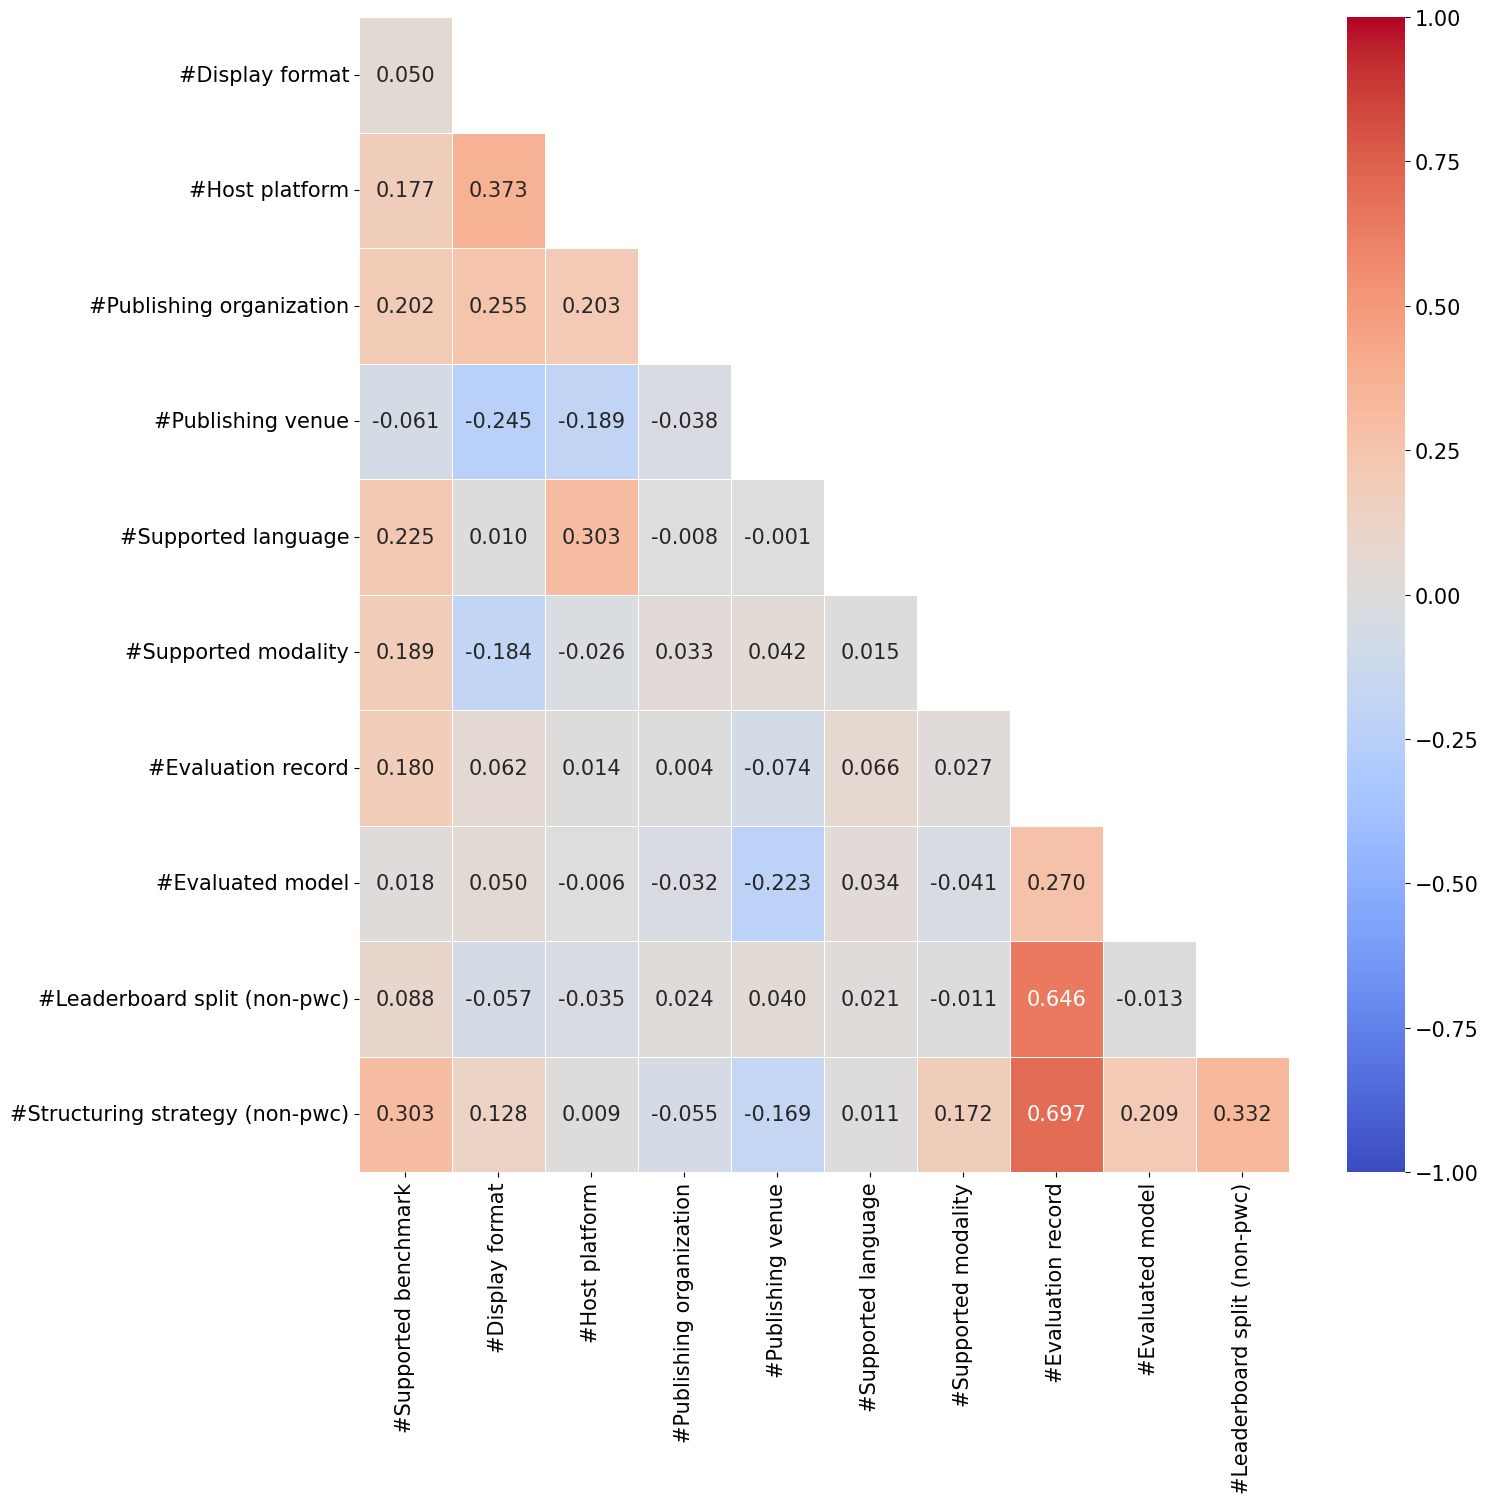

In [33]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.drop(columns=['#Evaluation metric (pwc)'])
corr_matrix = numeric_df.corr()

# Drop the first row
corr_matrix_dropped_row = corr_matrix.drop(corr_matrix.index[0])

# Drop the last column
corr_matrix_dropped = corr_matrix_dropped_row.drop(corr_matrix_dropped_row.columns[-1], axis=1)

# Generate a mask for the upper triangle, including the diagonal
mask = np.triu(np.ones_like(corr_matrix_dropped, dtype=bool), 1)

# Generate a heatmap for the correlation matrix with the mask
plt.figure(figsize=(15,15))
ax = sns.heatmap(corr_matrix_dropped, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, mask=mask, vmin=-1, vmax=1, annot_kws={"size": font_size})
# Enlarge axis font size
ax.tick_params(axis='both', which='major', labelsize=font_size)
# Adjust color bar (color scale) font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font_size)  # Adjusts the tick labels' font size

# plt.title('Correlation Matrix Heatmap for Leaderboard Attributes')
plt.savefig(path_rq1 / 'leaderboard attribute heatmap.pdf', format='pdf')
plt.show()


In [227]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df = df[df['Structuring strategies (non-pwc)'].map(len) > 0]
print(f"{len(df[df['#Empty leaderboards (non-pwc)'].notna()])} multi-scenario leaderboards (excluding PapersWithCode) have missing scenarios, accounting for {round(len(df[df['#Empty leaderboards (non-pwc)'].notna()])/len(df)*100,2)}% of the total.")
df['#Empty leaderboards (non-pwc)'].value_counts().reset_index(name='Frequency')

4 multi-scenario leaderboards (excluding PapersWithCode) have missing scenarios, accounting for 1.21% of the total.


,#Empty leaderboards (non-pwc),Frequency
0,2,2
1,?,2


Rankable Table is the most prevalent display format adopted by 97 leaderboards.


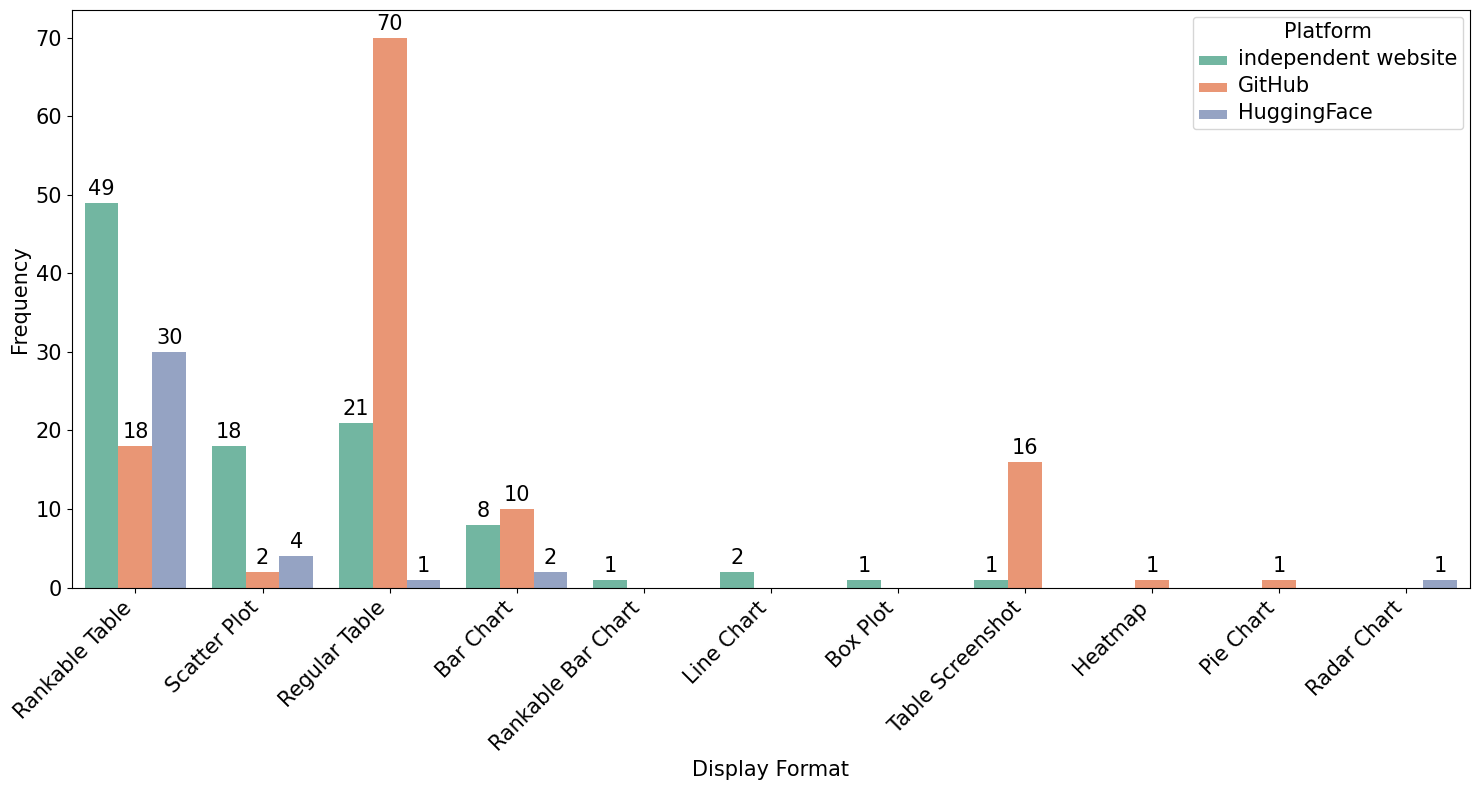

In [5]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Display format (non-pwc)'] = df['Display format (non-pwc)'].apply(ast.literal_eval)

format_counts = defaultdict(lambda: defaultdict(int))
for index, row in df.iterrows():
    # Loop through each platform and its formats in the dictionary
    for platform, formats in row['Display format (non-pwc)'].items():
        for format_type in formats:
            # Increment the count for the format type under its respective platform
            format_counts[platform][format_type] += 1
            
flattened_data = []
for platform, formats in format_counts.items():
    for format_type, count in formats.items():
        flattened_data.append({'Platform': platform, 'Display Format': format_type, 'Frequency': count})
        
format_counts_df = pd.DataFrame(flattened_data)
format_counts_df_only = format_counts_df.groupby('Display Format').sum().reset_index()
format_counts_df_only['Weight'] = 1

statistics = {
    'Property': 'Distribution of Leaderboard across Display Formats',
    'Mean': round(np.mean(format_counts_df_only['Frequency']), 2),
    'Median': np.median(format_counts_df_only['Frequency']),
    'Mode': stats.mode(format_counts_df_only['Frequency'])[0],
    'Standard Deviation': round(np.std(format_counts_df_only['Frequency']), 2),
    'Gini Coefficient': round(ineqpy.inequality.gini(data=format_counts_df_only, income='Frequency', weights='Weight'), 3),
}
if os.path.exists(path_rq1 / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = format_counts_df_only.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Display Format'].iloc[0]} is the most prevalent display format adopted by {df_top['Frequency'].iloc[0]} leaderboards.")

# Plotting
plt.figure(figsize=(15, 8))  # Adjust figure size as needed
ax = sns.barplot(
    x='Display Format', 
    y='Frequency', 
    hue='Platform',  # This separates the bars within each group by platform
    data=format_counts_df, 
    palette='Set2',  # Choose a palette that makes the bars distinct
    dodge=True  # Adjust this to control the gap between bars of different platforms within the same group
)

# Setting the title and labels with enlarged fonts
ax.set_xlabel('Display Format', fontsize=font_size)  # Enlarge x-axis label
ax.set_ylabel('Frequency', fontsize=font_size)  # Enlarge y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Enlarge axis ticks font size
ax.tick_params(axis='both', which='major', labelsize=font_size)

# Adding annotations on top of each bar
for p in ax.patches:
    if p.get_height():
        ax.annotate(format(p.get_height(), '.0f'),  # Format the number displayed
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                ha = 'center', va = 'center', 
                xytext = (0, 10),  # Distance from the top of the bar
                textcoords = 'offset points', fontsize=font_size)

# Adjust the legend
leg = ax.legend(title='Platform')
leg.set_title('Platform', prop={'size':font_size})  # Set the title font size
for text in leg.get_texts():  # Set the font size for each legend text
    text.set_fontsize(font_size)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
# Save the plot to a PDF file
plt.savefig(path_rq1 / 'display format distribution.pdf', bbox_inches='tight')
plt.show()


In [224]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

statistics = {
    'Property': 'Distribution of Display Format across Leaderboards',
    'Mean': round(np.mean(df['#Display format']), 2),
    'Median': np.median(df['#Display format']),
    'Mode': stats.mode(df['#Display format'])[0],
    'Standard Deviation': round(np.std(df['#Display format']), 2),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Display format', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of display format up to {int(df_top['#Display format'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Display format'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Display format'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Display Format',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

Models Leaderboard supports the highest number of display format up to 5.


In [244]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
print(f"Only {len(df[df['Host platforms'].map(len) > 1])} publishers host their leaderboards on multiple platforms, accounting for {round(len(df[df['Host platforms'].map(len) > 1])/len(df),4)*100}% of the total.")

df_split = df.explode('Host platforms')['Host platforms'].value_counts().reset_index(name='Frequency')
print(f"{df_split['Host platforms'].iloc[0]} is the most popular host platform, accounting for {round(df_split['Frequency'].iloc[0]/len(df)*100,2)}% leaderboards.")
df_split['Weight'] = 1

statistics = {
    'Property': 'Distribution of Leaderboard across Host Platforms',
    'Mean': round(np.mean(df_split['Frequency']), 2),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': round(np.std(df_split['Frequency']), 2),
    'Gini Coefficient': round(ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'), 3),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

fig = px.bar(
    x=df_split['Host platforms'],
    y=df_split['Frequency'],
    text_auto=True,
    labels={'x': 'Host platforms', 'y': 'Number of Leaderboards'},
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

Only 32 publishers host their leaderboards on multiple platforms, accounting for 9.67% of the total.
PapersWithCode is the most popular host platform, accounting for 49.85% leaderboards.


In [226]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

statistics = {
    'Property': 'Distribution of Host Platforms across Leaderboards',
    'Mean': round(np.mean(df['#Host platform']), 2),
    'Median': np.median(df['#Host platform']),
    'Mode': stats.mode(df['#Host platform'])[0],
    'Standard Deviation': round(np.std(df['#Host platform']), 2),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Host platform', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of host platforms up to {int(df_top['#Host platform'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Host platform'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Host platform'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Host Platforms',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

MTEB supports the highest number of host platforms up to 4.


In [238]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
df = df[(df['Host platforms'].apply(len) == 1) & (platform_abbreviation_mapping['pwc'] not in df['Host platforms'])]
# df_pub = df[df['Publishing organizations (non-pwc)'].apply(len) > 0]
# print(f'{len(df_pub)} has at least one publishing organization, accounting for {round(len(df_pub)/len(df),4)*100}% of the total.')


299 has at least one publishing organization, accounting for 100.0% of the total.


In [9]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df = df[df['Host platforms'] != "['PapersWithCode']"]

df['Publishing organizations (non-pwc)'] = df['Publishing organizations (non-pwc)'].apply(ast.literal_eval)
df_split = df.explode('Publishing organizations (non-pwc)').groupby('Publishing organizations (non-pwc)').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Property': 'Distribution of Leaderboards across Publishing Organizations (non-pwc)',
    'Mean': round(np.mean(df_split['Frequency']), 2),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': round(np.std(df_split['Frequency']), 2),
    'Gini Coefficient': round(ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'), 3),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Publishing organizations (non-pwc)'].iloc[0]} is the most productive publisher among the {len(df)} publishers, accounting for {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Publishing organizations (non-pwc)'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Leaderboards across Publishing organizations (Top 10)',
        xaxis_title='Leaderboard Number',
        yaxis_title='Publisher Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.show()


Allen Institute for AI is the most productive publisher among the 170 publishers, accounting for 13.53% (23 out of 170) leaderboards.


In [17]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

statistics = {
    'Property': 'Distribution of Publishing Organization across Leaderboards',
    'Mean': round(np.mean(df['#Publishing organization']), 2),
    'Median': np.median(df['#Publishing organization']),
    'Mode': stats.mode(df['#Publishing organization'])[0],
    'Standard Deviation': round(np.std(df['#Publishing organization']), 2),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Publishing organization', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} holds the highest number of publishing organizations up to {int(df_top['#Publishing organization'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Publishing organization'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Publishing organization'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Publishing Organization',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


TrustLLM holds the highest number of publishing organizations up to 36.


In [8]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df_pub = df[df['#Publishing venue'] > 0]
print(f"{len(df_pub)} leaderboards are associated with specific publications, including articles, preprints, and reports, accounting for {round(len(df_pub)/len(df)*100,2)}% of the total.")

df_pub['Publishing venues'] = df_pub['Publishing venues'].apply(ast.literal_eval)
df_accepted = df_pub[df_pub['Publishing venues'].apply(lambda x: 'Preprint' not in x)]
print(f"{len(df_accepted)} articles have been accepted in a specific workshop, conference and journal, accounting for {round(len(df_accepted)/len(df)*100,2)}% of the total publications.")

df_split = df_accepted.explode('Publishing venues').groupby('Publishing venues').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Property': 'Distribution of Leaderboards across Publishing Venues',
    'Mean': round(np.mean(df_split['Frequency']), 2),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': round(np.std(df_split['Frequency']), 2),
    'Gini Coefficient': round(ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'), 3),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Publishing venues'].iloc[0]} emerges as the conference with most number of accepted articles, accounting for {round(df_top['Frequency'].iloc[0]/len(df_accepted)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df_accepted)}) of the total.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Publishing venues'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Leaderboards with Accepted Articles across Publishing Venues (Top 10)',
        xaxis_title='Leaderboard Number',
        yaxis_title='Publication Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.show()


298 leaderboards are associated with specific publications, including articles, preprints, and reports, accounting for 90.03% of the total.
192 articles have been accepted in a specific workshop, conference and journal, accounting for 58.01% of the total publications.
EMNLP emerges as the conference with most number of accepted articles, accounting for 15.62% (30 out of 192) of the total.


/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_956/1977840573.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df = df[df['Host platforms'] != "['PapersWithCode']"]

df_split = df[df['#Structuring strategy (non-pwc)'] > 1]
print(f'{len(df_split)} leaderboards have adopted multiple structuring strategies, accounting for {round(len(df_split)/len(df)*100,2)}% of the total.')

statistics = {
    'Property': 'Distribution of Structuring Strategies across Leaderboards (non-pwc)',
    'Mean': round(np.mean(df_split['#Structuring strategy (non-pwc)']), 2),
    'Median': np.median(df_split['#Structuring strategy (non-pwc)']),
    'Mode': stats.mode(df_split['#Structuring strategy (non-pwc)'])[0],
    'Standard Deviation': round(np.std(df_split['#Structuring strategy (non-pwc)']), 2),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Structuring strategy (non-pwc)', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has adopted the highest number of structuring strategies up to {int(df_top['#Structuring strategy (non-pwc)'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Structuring strategy (non-pwc)'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Structuring strategy (non-pwc)'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Structuring Strategy',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


46 leaderboards have adopted multiple structuring strategies, accounting for 27.06% of the total.
HELM Classic has adopted the highest number of structuring strategies up to 10.


In [41]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df = df[df['Host platforms'] != "['PapersWithCode']"]
df_split = df[df['#Structuring strategy (non-pwc)'] > 0]
print(f'{len(df_split)} leaderboards have adopted multiple structuring strategies, accounting for {round(len(df_split)/len(df)*100,2)}% of the total.')

df_split['Structuring strategies (non-pwc)'] = df_split['Structuring strategies (non-pwc)'].apply(ast.literal_eval)
df_split2 = df_split.explode('Structuring strategies (non-pwc)').groupby('Structuring strategies (non-pwc)').size().reset_index(name='Frequency')
df_split2['Weight'] = 1

statistics = {
    'Property': 'Distribution of Leaderboards across Structuring Strategies (non-pwc)',
    'Mean': round(np.mean(df_split2['Frequency']), 2),
    'Median': np.median(df_split2['Frequency']),
    'Mode': stats.mode(df_split2['Frequency'])[0],
    'Standard Deviation': round(np.std(df_split2['Frequency']), 2),
    'Gini Coefficient': round(ineqpy.inequality.gini(data=df_split2, income='Frequency', weights='Weight'), 3),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split2.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Structuring strategies (non-pwc)'].iloc[0]} is the most adopted structuring strategies, covering {round(df_top['Frequency'].iloc[0]/len(df_split)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df_split)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Structuring strategies (non-pwc)'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Structuring Strategy',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


83 leaderboards have adopted multiple structuring strategies, accounting for 48.82% of the total.
Task is the most adopted structuring strategies, covering 37.35% (31 out of 83) leaderboards.


/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_956/4175654274.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df = df[df['Host platforms'] != "['PapersWithCode']"]
df = df[df['#Structuring strategy (non-pwc)'] > 0]
df['Structuring strategies (non-pwc)'] = df['Structuring strategies (non-pwc)'].apply(ast.literal_eval)
df_split = df.explode('Structuring strategies (non-pwc)')

df_number = pd.DataFrame()
for index, (name, group) in enumerate(df_split.groupby('Structuring strategies (non-pwc)')):
    entry = {
        'Index': index, # Temporarily store the original index
        'Major category': leaderboard_organization_strategies_mapping_inverse[name],
        'Structuring strategy': name,
        'Prevalence (%)': len(group)/len(df)*100,
    }
    df_number = pd.concat([df_number, pd.DataFrame([entry])], ignore_index=True)

df_number = df_number.sort_values(by=['Major category', 'Structuring strategy']).reset_index(drop=True)
df_number['Index'] = df_number.index + 1
df_number['Index'] = df_number['Index'].apply(lambda x: f'$C_{{0{x}}}$' if x < 10 else f'$C_{{{x}}}$')
print(df_number.to_latex(float_format="%.2f", index=False))

df_split['Major structuring strategy'] = df_split['Structuring strategies (non-pwc)'].map(leaderboard_organization_strategies_mapping_inverse)
df_split2 = df_split['Major structuring strategy'].value_counts().reset_index(name='Frequency')
fig = px.bar(
    title='Distribution of Leaderboards across Major Structuring Strategies (non-pwc)',
    x=df_split2['Major structuring strategy'],
    y=df_split2['Frequency'],
    text_auto=True,
    labels={'x': 'Major Structuring Strategy', 'y': 'Leaderboard Number'},
)
fig.show()

\begin{tabular}{lllr}
\toprule
Index & Major category & Structuring strategy & Prevalence (%) \\
\midrule
$C_{01}$ & Evaluation Configuration & Evaluation Dataset & 16.87 \\
$C_{02}$ & Evaluation Configuration & Evaluation Metric & 13.25 \\
$C_{03}$ & Evaluation Configuration & Evaluator & 6.02 \\
$C_{04}$ & Leaderboard Layout & Aggregated Result & 33.73 \\
$C_{05}$ & Leaderboard Release & Leaderboard Launch Date & 2.41 \\
$C_{06}$ & Leaderboard Release & Leaderboard Version & 3.61 \\
$C_{07}$ & Model Capability & Benchmark & 14.46 \\
$C_{08}$ & Model Capability & Service Load & 4.82 \\
$C_{09}$ & Model Capability & Supported Functionality & 26.51 \\
$C_{10}$ & Model Capability & Supported Language & 10.84 \\
$C_{11}$ & Model Capability & Supported Modality & 3.61 \\
$C_{12}$ & Model Capability & Task & 37.35 \\
$C_{13}$ & Model Information & Model Accessibility & 6.02 \\
$C_{14}$ & Model Information & Model Size & 3.61 \\
$C_{15}$ & Model Information & Model Type & 2.41 \\
$C_{16}$ & 

In [10]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

statistics = {
    'Property': 'Distribution of Supported Languages across Leaderboards',
    'Mean': round(np.mean(df['#Supported language']), 2),
    'Median': np.median(df['#Supported language']),
    'Mode': stats.mode(df['#Supported language'])[0],
    'Standard Deviation': round(np.std(df['#Supported language']), 2),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported language', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of languages up to {int(df_top['#Supported language'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Supported language'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Supported language'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Supported Languages',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


MTEB supports the highest number of languages up to 112.


In [15]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Supported languages'] = df['Supported languages'].apply(ast.literal_eval)

df_split = df.explode('Supported languages').groupby('Supported languages').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Property': 'Distribution of Leaderboards across Supported Languages (non-pwc)',
    'Mean': round(np.mean(df_split['Frequency']), 2),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': round(np.std(df_split['Frequency']), 2),
    'Gini Coefficient': round(ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'), 3),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Supported languages']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Supported languages'].iloc[0]} is the most supported language by {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Supported languages'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Supported language',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

English is the most supported language by 89.43% (296 out of 331) leaderboards.


In [16]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

statistics = {
    'Property': 'Distribution of Supported Modalities across Leaderboards',
    'Mean': round(np.mean(df['#Supported modality']), 2),
    'Median': np.median(df['#Supported modality']),
    'Mode': stats.mode(df['#Supported modality'])[0],
    'Standard Deviation': round(np.std(df['#Supported modality']), 2),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported modality', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of modality up to {int(df_top['#Supported modality'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Supported modality'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Supported modality'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Supported Modality',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


FlagEval supports the highest number of modality up to 4.


In [24]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Supported modalities'] = df['Supported modalities'].apply(ast.literal_eval)

df_split = df.explode('Supported modalities').groupby('Supported modalities').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Property': 'Distribution of Leaderboards across Supported Modalities (non-pwc)',
    'Mean': round(np.mean(df_split['Frequency']), 2),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': round(np.std(df_split['Frequency']), 2),
    'Gini Coefficient': round(ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'), 3),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Supported modalities']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Supported modalities'].iloc[0]} is the most supported modality by {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Supported modalities'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Supported Modality',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

Text is the most supported modality by 100.0% (331 out of 331) leaderboards.


In [22]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

statistics = {
    'Property': 'Distribution of Supported Benchmarks across Leaderboards',
    'Mean': round(np.mean(df['#Supported benchmark']), 2),
    'Median': np.median(df['#Supported benchmark']),
    'Mode': stats.mode(df['#Supported benchmark'])[0],
    'Standard Deviation': round(np.std(df['#Supported benchmark']), 2),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported benchmark', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of {int(df_top['#Supported benchmark'].iloc[0])} benchmarks.")

fig = go.Figure(go.Bar(
        x=df_top['#Supported benchmark'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Supported benchmark'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Supported Benchmarks',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


BIG-Bench supports the highest number of 209 benchmarks.


In [26]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Supported benchmarks'] = df['Supported benchmarks'].apply(ast.literal_eval)

df_split = df.explode('Supported benchmarks').groupby('Supported benchmarks').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Property': 'Distribution of Leaderboards across Supported Benchmarks (non-pwc)',
    'Mean': round(np.mean(df_split['Frequency']), 2),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': round(np.std(df_split['Frequency']), 2),
    'Gini Coefficient': round(ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'), 3),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Supported benchmarks']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Supported benchmarks'].iloc[0]} is the most supported benchmark by {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Supported benchmarks'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Supported Benchmark',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

MMLU is the most supported benchmark by 4.83% (16 out of 331) leaderboards.


In [29]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

statistics = {
    'Property': 'Distribution of Evaluated Models across Leaderboards',
    'Mean': round(np.mean(df['#Evaluated model']), 2),
    'Median': np.median(df['#Evaluated model']),
    'Mode': stats.mode(df['#Evaluated model'])[0],
    'Standard Deviation': round(np.std(df['#Evaluated model']), 2),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Evaluated model', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Evaluated model'].iloc[0])} models evaluated.")

fig = go.Figure(go.Bar(
        x=df_top['#Evaluated model'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Evaluated model'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Evaluated Models',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


Open LLM Leaderboard has the highest number of 4057 models evaluated.


In [30]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Evaluated models'] = df['Evaluated models'].apply(ast.literal_eval)

df_split = df.explode('Evaluated models').groupby('Evaluated models').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Property': 'Distribution of Leaderboards across Evaluated Models (non-pwc)',
    'Mean': round(np.mean(df_split['Frequency']), 2),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': round(np.std(df_split['Frequency']), 2),
    'Gini Coefficient': round(ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'), 3),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Evaluated models']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Evaluated models'].iloc[0]} is the most prevalent model evaluated in {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Evaluated models'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Evaluated Model',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

GPT-4 is the most prevalent model evaluated in 16.01% (53 out of 331) leaderboards.


In [35]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df = df[df['Host platforms'] == "['PapersWithCode']"]

statistics = {
    'Property': 'Distribution of Evaluation Metrics across Leaderboards (pwc)',
    'Mean': round(np.mean(df['#Evaluation metric (pwc)']), 2),
    'Median': np.median(df['#Evaluation metric (pwc)']),
    'Mode': stats.mode(df['#Evaluation metric (pwc)'])[0],
    'Standard Deviation': round(np.std(df['#Evaluation metric (pwc)']), 2),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Evaluation metric (pwc)', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Evaluation metric (pwc)'].iloc[0])} evaluation metrics.")

fig = go.Figure(go.Bar(
        x=df_top['#Evaluation metric (pwc)'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Evaluation metric (pwc)'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Evaluation Metrics',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


MSCOCO has the highest number of 19 evaluation metrics.


In [36]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df = df[df['Host platforms'] == "['PapersWithCode']"]
df['Evaluation metrics (pwc)'] = df['Evaluation metrics (pwc)'].apply(ast.literal_eval)

df_split = df.explode('Evaluation metrics (pwc)').groupby('Evaluation metrics (pwc)').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Property': 'Distribution of Leaderboards across Evaluation Metrics (pwc)',
    'Mean': round(np.mean(df_split['Frequency']), 2),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': round(np.std(df_split['Frequency']), 2),
    'Gini Coefficient': round(ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'), 3),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
if statistics['Property'] in df_statistics['Property'].values:
    # If the id exists, update the row
    df_statistics = df_statistics[df_statistics['Property'] != statistics['Property']]  # Remove the old row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)  # Insert the new row
else:
    # If the id does not exist, insert the new row
    df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.sort_values(by='Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Evaluation metrics (pwc)']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Evaluation metrics (pwc)'].iloc[0]} is the most prevalent evaluation metrics in {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Evaluation metrics (pwc)'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Evaluation Metric',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

accuracy is the most prevalent evaluation metrics in 45.34% (73 out of 161) leaderboards.


In [37]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df = df[df['Host platforms'] != "['PapersWithCode']"]

statistics = {
    'Property': 'Distribution of Splits across Leaderboards (pwc)',
    'Mean': round(np.mean(df['#Leaderboard split (non-pwc)']), 2),
    'Median': np.median(df['#Leaderboard split (non-pwc)']),
    'Mode': stats.mode(df['#Leaderboard split (non-pwc)'])[0],
    'Standard Deviation': round(np.std(df['#Leaderboard split (non-pwc)']), 2),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Leaderboard split (non-pwc)', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Leaderboard split (non-pwc)'].iloc[0])} leaderboard splits.")

fig = go.Figure(go.Bar(
        x=df_top['#Leaderboard split (non-pwc)'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Leaderboard split (non-pwc)'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Split Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


LMExamQA has the highest number of 887 leaderboard splits.


In [38]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

statistics = {
    'Property': 'Distribution of Evaluation Records across Leaderboards',
    'Mean': round(np.mean(df['#Evaluation record']), 2),
    'Median': np.median(df['#Evaluation record']),
    'Mode': stats.mode(df['#Evaluation record'])[0],
    'Standard Deviation': round(np.std(df['#Evaluation record']), 2),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Evaluation record', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Evaluation record'].iloc[0])} evaluation records.")

fig = go.Figure(go.Bar(
        x=df_top['#Evaluation record'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Evaluation record'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Evaluation Records',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


HELM Classic has the highest number of 16005 evaluation records.


In [86]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
df['Host platforms'] = df['Host platforms'].apply(filter_platform, filters=['pwc'])
df = df[df['Host platforms'].map(len) > 0]

df['Host platforms with model linkage (non-pwc)'] = df['Host platforms with model linkage (non-pwc)'].apply(ast.literal_eval)
print(f"{len(df[df['Host platforms with model linkage (non-pwc)'].map(len) > 0])} non-template leaderboards have accessible linkage to the evaluated models in their leaderboards, accounting for {round(len(df[df['Host platforms with model linkage (non-pwc)'].map(len) > 0])/len(df),4)*100}% of the total.")
df_provenance = df[df['Host platforms with model linkage (non-pwc)'].map(len) > 0]
df_provenance = df_provenance.explode('Host platforms with model linkage (non-pwc)')
df_provenance['Host platforms with model linkage (non-pwc)'] = df_provenance['Host platforms with model linkage (non-pwc)'].map(platform_abbreviation_mapping)
df_provenance = df_provenance['Host platforms with model linkage (non-pwc)'].value_counts().reset_index()

fig = px.bar(
    x=df_provenance['Host platforms with model linkage (non-pwc)'],
    y=df_provenance['count'],
    text_auto=True,
    labels={'x': 'Host platforms', 'y': 'Count of leaderboards with model provenance linkage'},
    title='Number of Leaderboards with Model Provenance Linkage across Platforms (non-pwc)'
)
# fig.write_image(path_rq1 / 'platform distribution.pdf')
fig.show()

total_data = 0
# total_paper = 0
# total_code = 0
total_provenance = 0

# average_paper_rate = []
# average_code_rate = []
average_provenance_rate = []

for root, dirs, files in os.walk(path_data):
    for file in files:
        if file.startswith('pwc') and file.endswith(".json"):
            with open(os.path.join(root, file), 'r') as file:
                json_data = json.load(file)
                total_data += len(json_data)
                json_external = [external for external in json_data if type(external['external_source_url']) == str]
                total_provenance += len(json_external)
                if not len(json_external):
                    json_internal = [paper for paper in json_data if type(paper['paper']['id']) == int]
                    total_provenance += len(json_internal)
                    average_provenance_rate.append(len(json_internal)/len(json_data))
                    # json_paper = [paper for paper in json_data if type(paper['paper']['id']) == int]
                    # total_paper += len(json_paper)
                    # average_paper_rate.append(len(json_paper)/len(json_data)*100)
                    # json_code = [code for code in json_paper if code['paper']['code'] == True]
                    # if len(json_code):
                    #     total_code += len(json_code)
                    #     average_code_rate.append(len(json_code)/len(json_paper)*100)

print(f'Total provenance rate across all leaderboard: {round(total_provenance/total_data, 4)*100}%, namely {total_provenance} out of {total_data} evaluation records.')
print(f'Average provenance rate across crowdsourced leaderboard: {round(sum(average_provenance_rate)/len(average_provenance_rate), 4)*100}%')


55 non-template leaderboards have accessible linkage to the evaluated models in their leaderboards, accounting for 39.86% of the total.


Total provenance rate across all leaderboard: 97.97%, namely 6628 out of 6765 evaluation records.
Average provenance rate across crowdsourced leaderboard: 98.95%


In [23]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
df['Host platforms'] = df['Host platforms'].apply(filter_platform, filters=['pwc'])
df = df[df['Host platforms'].map(len) > 0]
        
df['Submission manners (non-pwc)'] = df['Submission manners (non-pwc)'].apply(ast.literal_eval)
df['Submission artifacts (non-pwc)'] = df['Submission artifacts (non-pwc)'].apply(ast.literal_eval)
print(f"Of the {len(df)} non-template leaderboards collected, {len(df[df['Submission manners (non-pwc)'].map(len) > 0])} (accounting for {round(len(df[df['Submission manners (non-pwc)'].map(len) > 0])/len(df)*100,2)}%) do not explicitly encourage the submission of evaluation records.")

df = df[df['Submission manners (non-pwc)'].map(len) > 0]
df_manner = df.explode('Submission manners (non-pwc)')
df_manner['Submission manners (non-pwc)'] = df_manner['Submission manners (non-pwc)'].apply(lambda x: submission_synonyms_inverse[x] if x in submission_synonyms_inverse else x)
df_manner = df_manner['Submission manners (non-pwc)'].value_counts().reset_index()
print(f"{df_manner['Submission manners (non-pwc)'].iloc[0]} is the most popular Submission manner for non-template leaderboards, accounting for {round(df_manner['count'].iloc[0]/len(df)*100,2)}% of the total.")

df_manner['Weight'] = 1
# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df_manner, income='count', weights='Weight')
print("Gini Coefficient:", gini_coefficient)

fig = px.bar(
    x=df_manner['Submission manners (non-pwc)'], 
    y=df_manner['count'],
    text_auto=True,
    labels={'x': 'Submission manner', 'y': 'Number of Leaderboards'},
    title='Number of Submission Manner across Non-template-based Leaderboards'
)
fig.write_image(path_rq1 / 'submission manner distribution.pdf')
fig.show()

df_artifact = df.explode('Submission artifacts (non-pwc)')
df_artifact = df_artifact['Submission artifacts (non-pwc)'].value_counts().reset_index()
print(f"{df_artifact['Submission artifacts (non-pwc)'].iloc[0]} is the most popular submission manner for non-template leaderboards, accounting for {round(df_artifact['count'].iloc[0]/len(df)*100,2)}% of the total.")

df_artifact['Weight'] = 1
# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df_artifact, income='count', weights='Weight')
print("Gini Coefficient:", gini_coefficient)

fig = px.bar(
    x=df_artifact['Submission artifacts (non-pwc)'],
    y=df_artifact['count'],
    text_auto=True,
    labels={'x': 'Submission artifact', 'y': 'Number of Leaderboards'},
    title='Number of Submission Artifact across Non-template-based Leaderboards'
)
# fig.write_image(path_rq1 / 'submission artifact distribution.pdf')
fig.show()

Of the 144 non-template leaderboards collected, 72 (accounting for 50.0%) do not explicitly encourage the submission of evaluation records.
Submission Portal is the most popular Submission manner for non-template leaderboards, accounting for 40.28% of the total.
Gini Coefficient: 0.5310077519379846


Evaluation Results is the most popular submission manner for non-template leaderboards, accounting for 73.61% of the total.
Gini Coefficient: 0.5793650793650793


In [32]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
df['Host platforms'] = df['Host platforms'].apply(filter_platform, filters=['pwc'])
for index, row in df.iterrows():
    if (len(row['Host platforms']) == 1) and (row['Host platforms'][0] == ['independent website']):
        continue
    df.drop(index, inplace=True)
    
df['Feedback manners (iw)'] = df['Feedback manners (iw)'].apply(ast.literal_eval)
print(f"Among leaderboards exclusively hosted on independent websites (up to {len(df)}), {round(len(df[df['Feedback manners (iw)'].map(len) > 0])/len(df)*100,2)}% of them provide feedback channels, with only {len(df[df['Feedback manners (iw)'].map(len) == 0])} exception.")
df_provenance = df[df['Feedback manners (iw)'].map(len) > 0]
df_provenance = df_provenance.explode('Feedback manners (iw)')
df_provenance = df_provenance['Feedback manners (iw)'].value_counts().reset_index()

fig = px.bar(
    x=df_provenance['Feedback manners (iw)'],
    y=df_provenance['count'],
    text_auto=True,
    labels={'x': 'Host platforms', 'y': 'Count of leaderboards with model provenance linkage'},
    title='Distribution Feedback Channels across Leaderboards Hosted on Independent Websites'
)
# fig.write_image(path_rq1 / 'platform distribution.pdf')
fig.show()

Among leaderboards exclusively hosted on independent websites (up to 27), 96.3% of them provide feedback channels, with only 1 exception.
